In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import bambi as bmb
import arviz as az

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl
Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concrete = pd.read_csv('concrete_data.csv')
concrete.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Bayesian Model

Exploratory Data Analysis

In [3]:
print(concrete.isna().any())
print(concrete.dtypes)

cement              False
slag                False
fly_ash             False
water               False
superplasticizer    False
coarse_aggregate    False
fine_aggregate      False
age                 False
strength            False
dtype: bool
cement              float64
slag                float64
fly_ash             float64
water               float64
superplasticizer    float64
coarse_aggregate    float64
fine_aggregate      float64
age                   int64
strength            float64
dtype: object


We don't have any missing values what is good.

We will not, for now, worriying with eventual Outliers

Our Bayesian will be as it follows

In [4]:
model_pre = 'strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age'

Looking to our variables we have a lot of dimension differences between them so we have to standardize it.

You can scale the variables and bambi will do the rest

In [5]:
model_pre = """strength ~ scale(cement) +
            scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) 
            + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"""

model = bmb.Model(model_pre, concrete)
model.build()

Let's plot the priors. This coefficients are what the Model think they should be before it sees the dataset.

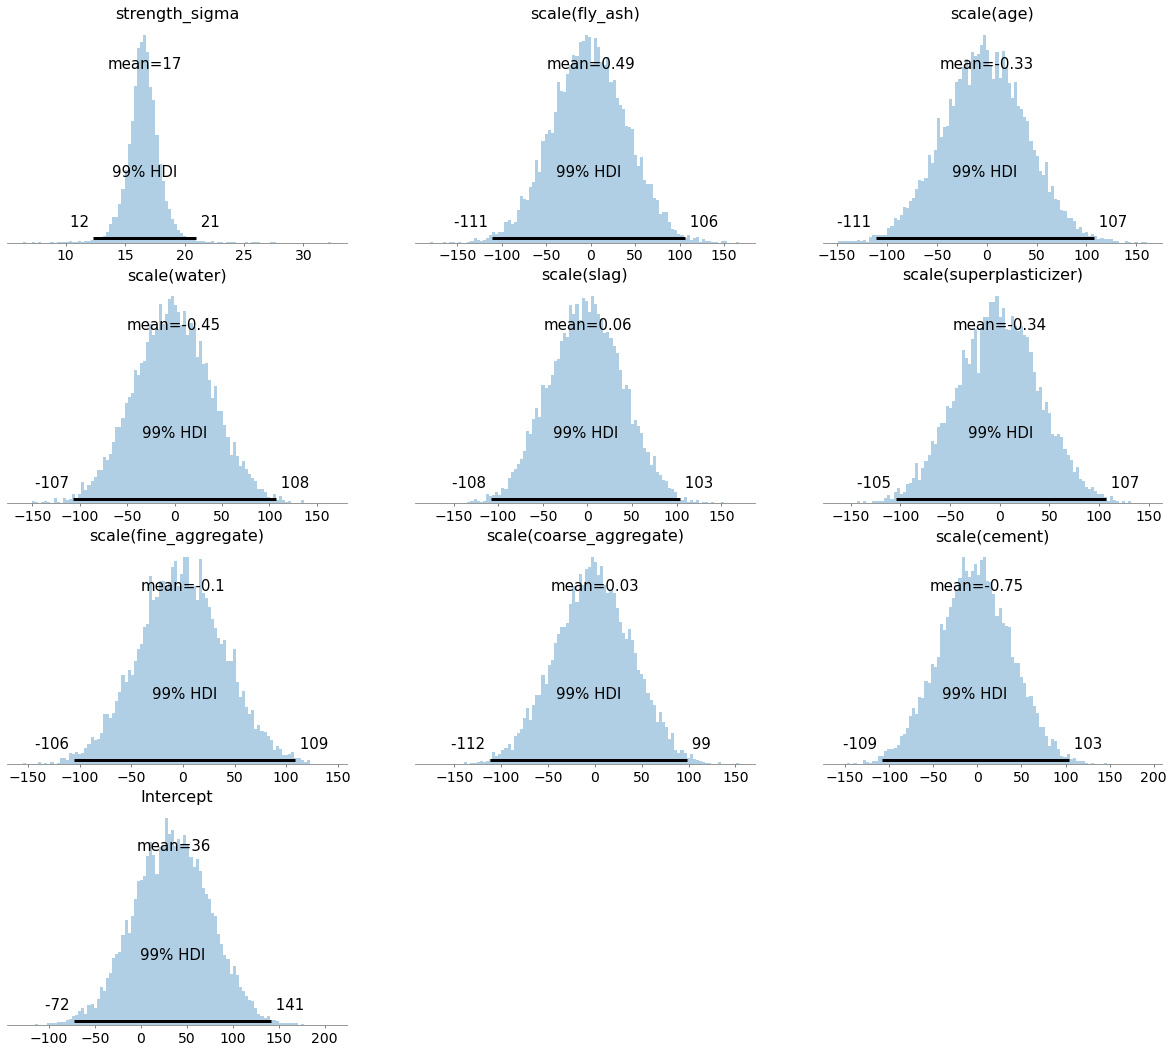

In [6]:
model.plot_priors(draws=10_000, hdi_prob=.99, kind='hist', bins=100)
plt.show()

This looks good enough. Most of our predictors are hovering 0, what is very good.

## Fit the Model

In [7]:
posterior_fit = model.fit(draws = 2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), strength_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 860 seconds.


After fitting the model let's check our posteriors.

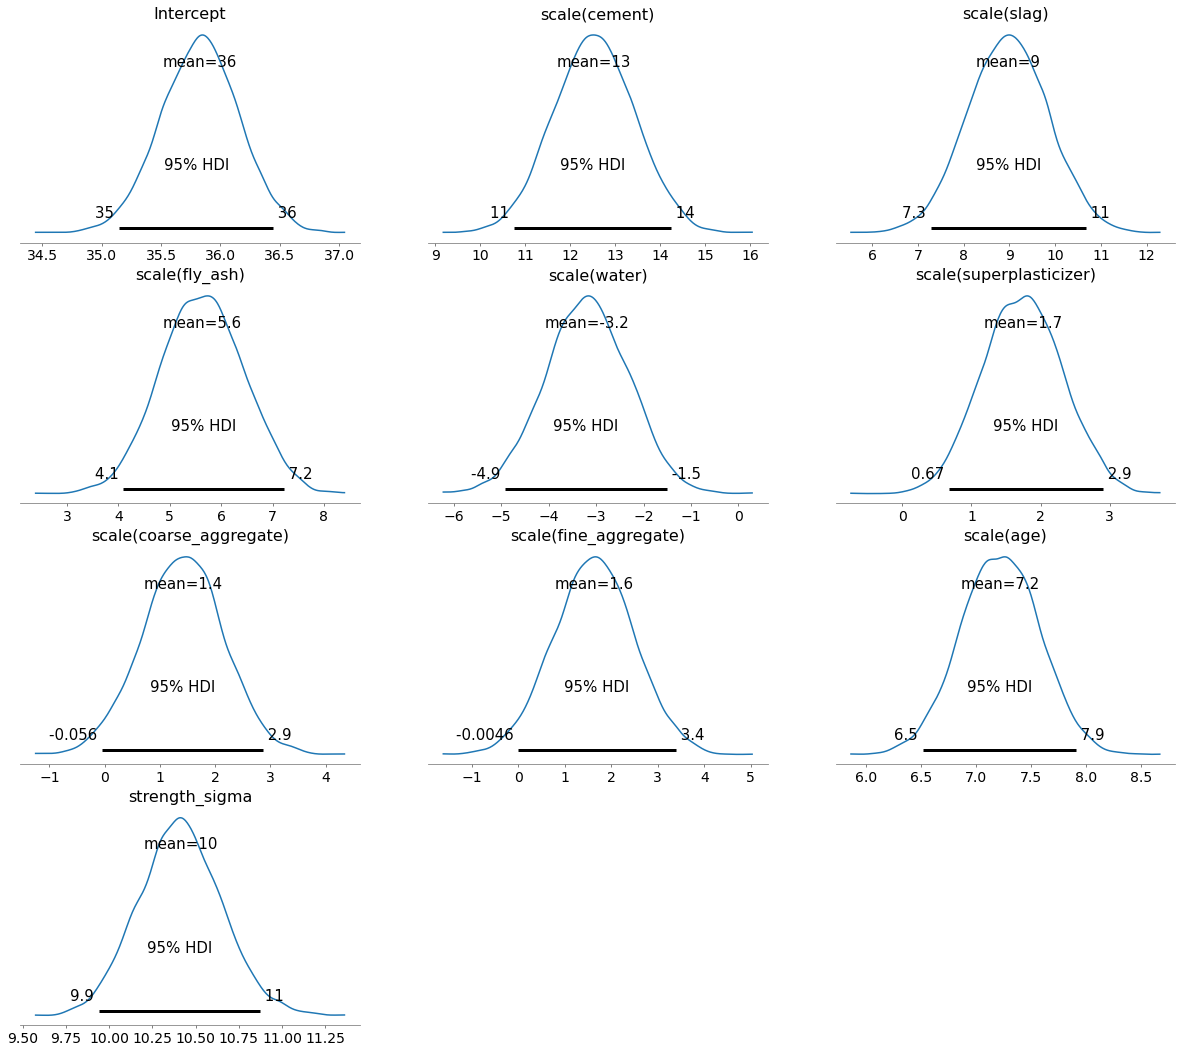

In [8]:
az.plot_posterior(posterior_fit, hdi_prob = 0.95)
plt.show()

To finalize let's predict the posteriors and verify if our posteriors predictions follow the data satisfactory

<AxesSubplot:xlabel='strength / strength'>

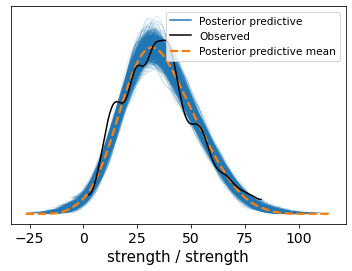

In [9]:
# Conduct a posterior predictive check
model.predict(posterior_fit, kind='pps')

# And plot
az.plot_ppc(posterior_fit, num_pp_samples=1000)

Analyzing the plot we conclude that our predictions are very close to the data observed.

So we are in conditions of predict the answer for the questions above.

First we will compute the mean of our variables without age that we want to make our predictions and strength to be predicted

In [10]:
to_predict = concrete.drop(columns=['age','strength']).mean().to_frame().T
to_predict

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate
0,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883


Then we will multiply the number of rows by four and assign the 4 values that we want to predict

In [11]:
to_predict = (pd.concat([to_predict] * 4, ignore_index=True).assign(age = [1, 7, 14, 28]))
to_predict

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,1
1,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,7
2,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,14
3,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,28


Now we will predict with the posteriors that we calculate when fit the model to the data.

But this time using the new data set 'to_predict'.

In [12]:
mean_predictions = model.predict(posterior_fit, kind='mean', data=to_predict, inplace=False)

Now we will select predictions for strength, stacking the number of chains and draws for the 40000 draws that we have.

After we will merge the dataframe 'to_predict' in the colum, and chcange the name of the columns

In [13]:
means = (mean_predictions['posterior']['strength_mean'].stack(draws=('chain', 'draw')).to_dataframe().reset_index()
         .merge(to_predict[['age']], left_on='strength_obs', right_index=True)
         .pivot(index=['chain', 'draw'], columns='age', values='strength_mean')
        )

means

age                1          7          14         28
chain draw                                            
0     0     30.869262  31.532547  32.306381  33.854047
      1     30.403081  31.091520  31.894698  33.501054
      2     30.413201  31.130802  31.968004  33.642406
      3     30.607052  31.263348  32.029027  33.560384
      4     31.079625  31.756996  32.547262  34.127793
...               ...        ...        ...        ...
3     1995  31.495432  32.199348  33.020583  34.663054
      1996  31.138206  31.807364  32.588049  34.149418
      1997  30.813530  31.493954  32.287781  33.875436
      1998  30.755789  31.429178  32.214798  33.786038
      1999  30.755789  31.429178  32.214798  33.786038

[8000 rows x 4 columns]

To finalize we will calculate the mean for every prediction that we did for this dataset

In [14]:
means.mean()

age
1     30.719444
7     31.405572
14    32.206055
28    33.807021
dtype: float64

To conclude we should expect streng of,

1 day = 30.712076

7 days = 31.398016

14 days = 32.198279

28 days = 33.798805